In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing dataset

In [ ]:
from mlxtend.data import loadlocal_mnist
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras 
from keras.utils.np_utils import to_categorical   

from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Conv2DTranspose, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
X_train, y_train = loadlocal_mnist(
            images_path='/content/gdrive/My Drive/Colab Notebooks/train-images.idx3-ubyte', 
            labels_path='/content/gdrive/My Drive/Colab Notebooks/train-labels.idx1-ubyte')
X_test, y_test = loadlocal_mnist(
            images_path='/content/gdrive/My Drive/Colab Notebooks/t10k-images.idx3-ubyte', 
            labels_path='/content/gdrive/My Drive/Colab Notebooks/t10k-labels.idx1-ubyte')

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
print('labels: %s' % np.unique(y_train))

labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
X_train = X_train[y_train==0]

In [ ]:
y_train = y_train[y_train==0]

In [ ]:
X_train.shape

(5923, 784)

In [ ]:
y_train.shape

(5923,)

In [ ]:
np.unique(y_train)

array([0], dtype=uint8)

In [ ]:
X_test = X_test[y_test==0]
y_test = y_test[y_test==0]

In [ ]:
X_test.shape

(980, 784)

In [ ]:
y_test.shape

(980,)

In [ ]:
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
print(y_train_bin)
y_test_bin = lb.fit_transform(y_test)

In [ ]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train).reshape(5923, 28, 28,1)
X_test_norm = mms.transform(X_test).reshape(980, 28, 28,1)

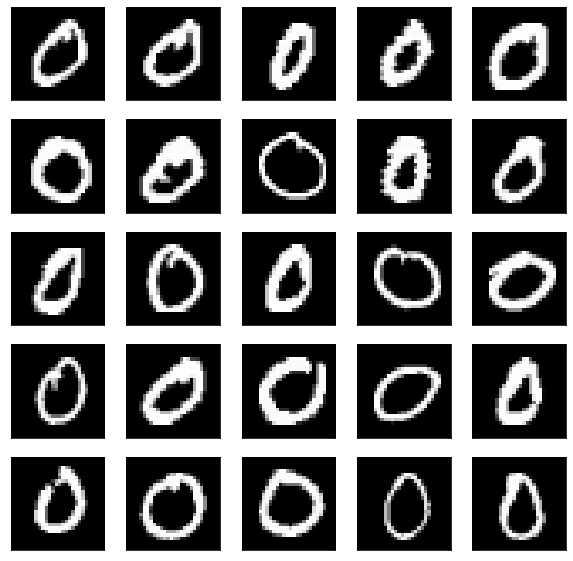

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_norm[i].reshape(28,28), cmap='gray')
plt.show()

# GAN - generowanie zera

In [ ]:
opt = keras.optimizers.Adam(lr=0.0002)
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.0002, decay=6e-8)

discriminator = tf.keras.Sequential(name='D')
discriminator.add(Conv2D(32, (3,3), input_shape=(28,28,1)))
discriminator.add(Activation('elu'))
discriminator.add(MaxPooling2D((2,2)))
discriminator.add(Conv2D(64, 3, activation='relu'))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(100))
discriminator.add(Activation('selu'))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

generator = tf.keras.Sequential(name='G')
generator.add(tf.keras.Input(shape=(14,)))
generator.add(Dense(196, activation='selu'))
generator.add(Dense(576, activation='relu'))
generator.add(Reshape((24,24,1)))
generator.add(Conv2DTranspose(64, 3, activation='relu'))
generator.add(Conv2DTranspose(1, 3, activation='elu'))
generator.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
generator.summary()

GAN = tf.keras.Sequential(name='GAN')
GAN.add(generator)
GAN.add(discriminator)
GAN.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               774500    

In [ ]:
X_fake_train = np.zeros((X_train_norm.shape[0], 14))
for sample in range(len(X_fake_train)):
  X_fake_train[sample] = np.random.normal(loc=0.5, scale=0.25, size=(14,))

In [ ]:
X_fake_train

array([[0.40455191, 0.60599506, 0.72076791, ..., 0.58907282, 0.27127084,
        0.45665785],
       [0.62774563, 0.74042194, 0.51951369, ..., 0.35898897, 0.40591586,
        0.4612857 ],
       [0.46251561, 0.68777716, 0.55329148, ..., 0.3443896 , 0.07532739,
        0.79018075],
       ...,
       [0.07351785, 0.22447724, 0.3836046 , ..., 0.82192877, 0.31473074,
        1.19006833],
       [0.77872042, 0.2881787 , 0.15967558, ..., 0.61426968, 1.10176988,
        0.20332173],
       [0.28086341, 0.46825313, 0.20436413, ..., 0.64508111, 0.35550446,
        0.89514042]])

In [ ]:
X_fake_generated_0 = generator.predict(X_fake_train)

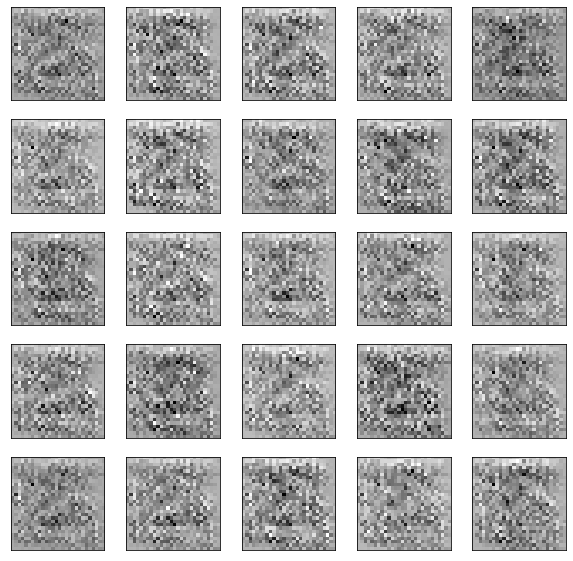

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_fake_generated_0[i].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
epochs = 200  #25 #2
component_epochs = 10 #2
X_fake = X_fake_generated_0
images_history = []

for epoch in range(epochs):
  print("\nEpoch: ", epoch+1, "\n")
  X_true_and_fake = np.concatenate((X_train_norm, X_fake.reshape(X_fake.shape[0],28,28,1)))
  y_true_and_fake = np.zeros(X_true_and_fake.shape[0])
  y_true_and_fake[:X_train_norm.shape[0]] = 1
  
  print("\nDiscriminator training:\n")
  discriminator.fit(X_true_and_fake, y_true_and_fake, epochs=component_epochs)
  for layer in discriminator.layers:
    layer.trainable = False
  
  noise = np.zeros((X_train_norm.shape[0], 14))
  for sample in range(len(noise)):
    noise[sample] = np.random.normal(loc=0.5, scale=0.25, size=(14,))
  y_noise = np.ones(noise.shape[0])

  print("\nGenerator training:\n")
  GAN.fit(noise, y_noise, epochs = component_epochs)

  X_fake = generator.predict(X_fake_train)
  images_history.append(X_fake[0])
  for layer in discriminator.layers:
    layer.trainable = True
  

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Epoch 10/10
186/186 [==============================] - 1s 6ms/step - loss: 7.1601e-14 - accuracy: 1.0000

Epoch:  99 


Discriminator training:

Epoch 1/10
371/371 [==============================] - 2s 4ms/step - loss: 0.3648 - accuracy: 0.9911
Epoch 2/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0033 - accuracy: 0.9997
Epoch 3/10
371/371 [==============================] - 2s 4ms/step - loss: 1.8659e-05 - accuracy: 1.0000
Epoch 4/10
371/371 [==============================] - 2s 5ms/step - loss: 3.1334e-04 - accuracy: 0.9999
Epoch 5/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 6/10
371/371 [==============================] - 2s 5ms/step - loss: 2.4818e-06 - accuracy: 1.0000
Epoch 7/10
371/371 [==============================] - 2s 5ms/step - loss: 0.0036 - accuracy: 0.9998
Epoch 8/10
371/371 [==============================] - 2s 4ms/step - loss: 2.45

In [ ]:
X_fake = generator.predict(X_fake_train)

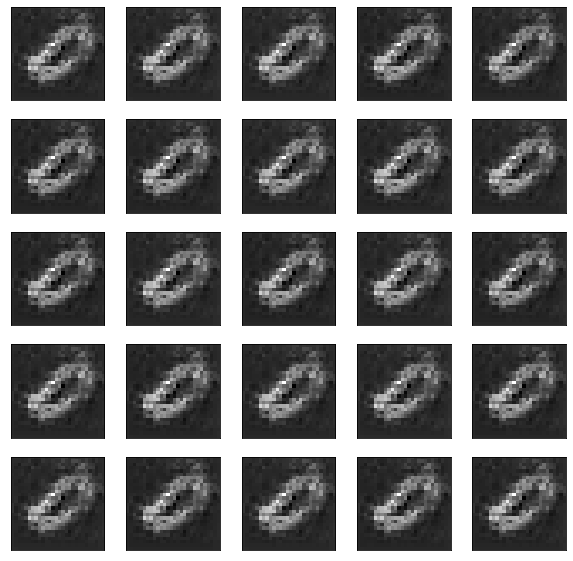

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_fake[i].reshape(28,28), cmap='gray')
plt.show()

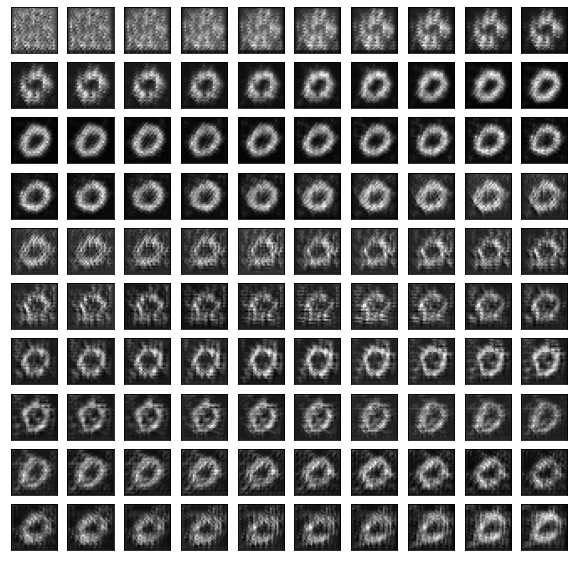

In [ ]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_history[i].reshape(28,28), cmap='gray')
plt.show()

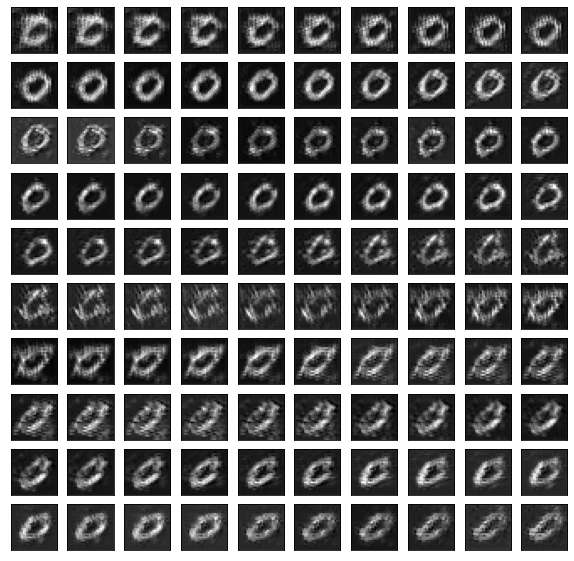

In [ ]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_history[100+i].reshape(28,28), cmap='gray')
plt.show()

# GAN - generowanie różnych liczb

In [ ]:
X_train2, y_train2 = loadlocal_mnist(
            images_path='/content/gdrive/My Drive/Colab Notebooks/train-images.idx3-ubyte', 
            labels_path='/content/gdrive/My Drive/Colab Notebooks/train-labels.idx1-ubyte')

In [ ]:
mms2 = MinMaxScaler()
X_train_norm2 = mms2.fit_transform(X_train2).reshape(60000, 28, 28,1)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_norm2[i].reshape(28,28), cmap='gray')
plt.show()

In [ ]:
opt = keras.optimizers.Adam(lr=0.0002)
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.0002, decay=6e-8)

discriminator2 = tf.keras.Sequential(name='D')
discriminator2.add(Conv2D(32, (3,3), input_shape=(28,28,1)))
discriminator2.add(Activation('elu'))
discriminator2.add(MaxPooling2D((2,2)))
discriminator2.add(Conv2D(64, 3, activation='relu'))
discriminator2.add(Dropout(0.5))
discriminator2.add(Flatten())
discriminator2.add(Dense(100))
discriminator2.add(Activation('selu'))
discriminator2.add(Dropout(0.5))
discriminator2.add(Dense(1))
discriminator2.add(Activation('sigmoid'))
discriminator2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator2.summary()

generator2 = tf.keras.Sequential(name='G')
generator2.add(tf.keras.Input(shape=(14,)))
generator2.add(Dense(196, activation='selu'))
generator2.add(Dense(576, activation='relu'))
generator2.add(Reshape((24,24,1)))
generator2.add(Conv2DTranspose(64, 3, activation='relu'))
generator2.add(Conv2DTranspose(1, 3, activation='elu'))
generator2.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
generator2.summary()

GAN2 = tf.keras.Sequential(name='GAN')
GAN2.add(generator2)
GAN2.add(discriminator2)
GAN2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
X_fake_train2 = np.zeros((X_train_norm2.shape[0], 14))
for sample in range(len(X_fake_train2)):
  X_fake_train2[sample] = np.random.normal(loc=0.5, scale=0.25, size=(14,))